# Financial Fraud Detection using Neuro-Symbolic AI Approach

## Neural Network with Logic-based Rules

---

**What is Neuro-Symbolic AI?**

- It is an approach to artificial intelligence that combines deep learning (neural networks) with symbolic reasoning to improve performance and overcome limitations of each method.
- This hybrid approach aims to leverage the pattern recognition and learning capabilities of neural networks with the logical, explainable, and structured reasoning of symbolic systems.

TL;DR: *Neuro-Symbolic = AI + Symbolic Reasoning*

**Benefits of this approach**:
- Improved Reasoning and Accuracy
- Enhanced Explainability
- Addressing Limitations of Large Language Models (LLMs)
- Efficient Learning
- Key Application Areas

---

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings("ignore")

# Data manipulations
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, classification_report
from sklearn.utils import check_random_state

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('All libraries are imported successfully.')

All libraries are imported successfully.


### Set up configurations for the model

In [2]:
@dataclass(frozen=True)
class Config:

  # Input Data
  csv_path: str = "/content/synthetic_financial_dataset.csv"
  sample_rows: int = 25000
  random_state: int = 42
  test_size: float = 0.20
  val_size: float = 0.20          # For training the combiner

  # Business Logic
  illegal_transfer_threshold: float = 200_000.0
  epsilon_balance: float = 1e-3   # Tolerance for balance mismatch

  # Neural Network
  max_iter_mlp: int = 60          # Can decrease for fast training
  hidden_layers: tuple = (24, 12) # Compact architecture
  class_weight: str | None = None

cfg = Config()

print(f"📋 Configuration loaded:")
print(f".  - Sample Size: {cfg.sample_rows:,} rows")
print(f".  - Illegal Transfer Threshold: ${cfg.illegal_transfer_threshold:,.0f}")
print(f"   - Neural network: {cfg.hidden_layers} hidden layers")

📋 Configuration loaded:
.  - Sample Size: 25,000 rows
.  - Illegal Transfer Threshold: $200,000
   - Neural network: (24, 12) hidden layers


In [8]:
def load_data(cfg: Config) -> pd.DataFrame:
  """Load and process input dataset."""

  df = pd.read_csv(cfg.csv_path)

  # Essential columns for fraud detection
  needed = [
      'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
      'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'
  ]

  missing = set(needed) - set(df.columns)
  if missing:
    raise ValueError(f"Missing columns: {sorted(missing)}")

  # Stratified sampling to maintain class balance
  if cfg.sample_rows and cfg.sample_rows < len(df):
    random_num_gen = check_random_state(cfg.random_state)

    # Keep balanced class representation
    fraud_idx = df[df['isFraud'] == 1].index.values
    legit_idx = df[df['isFraud'] != 1].index.values

    take_fraud = min(len(fraud_idx), cfg.sample_rows // 10)
    take_legit = cfg.sample_rows - take_fraud

    fraud_sample = random_num_gen.choice(fraud_idx, size=take_fraud, replace=False)
    legit_sample = random_num_gen.choice(legit_idx, size=take_legit, replace=False)

    df = df.loc[np.concatenate([fraud_sample, legit_sample])]
    df = df.sample(frac=1, random_state=cfg.random_state) # Shuffle data

  return df.reset_index(drop=True)

# Load the data
df = load_data(cfg)

print(f"📊 Loaded dataset successfully.")
print(f"   - Total Transactions: {len(df):,}")
print(f"   - Fradulent: {df['isFraud'].sum():,} ({df['isFraud'].mean()*100:.2f}%)")
print(f"   - Legitimate: {(~df['isFraud'].astype(bool)).sum():,} ({(1-df['isFraud'].mean())*100:.2f}%)")

print("\n📈 Transaction types distribution:")
print(df['type'].value_counts())

📊 Loaded dataset successfully.
   - Total Transactions: 25,000
   - Fradulent: 2,089.0 (8.36%)
   - Legitimate: 22,911 (91.64%)

📈 Transaction types distribution:
type
CASH_OUT    9297
PAYMENT     7616
CASH_IN     5032
TRANSFER    2908
DEBIT        147
Name: count, dtype: int64


### Exploratory Data Analysis

In [9]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,130,CASH_OUT,87595.74,C286715222,138219.0,50623.26,C486045077,0.00,87595.74,0.0,0.0
1,15,CASH_IN,300480.90,C1936546611,219144.0,519624.90,C806802665,154964.61,0.00,0.0,0.0
2,35,PAYMENT,8278.42,C261033017,12127.0,3848.58,M1913197460,0.00,0.00,0.0,0.0
3,163,PAYMENT,19676.82,C1364741571,0.0,0.00,M829725316,0.00,0.00,0.0,0.0
4,17,CASH_OUT,85014.62,C424650691,0.0,0.00,C1981752351,2457009.85,2561185.48,0.0,0.0


In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,25000.000000,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,25000.000000,25000.0
mean,91.945040,2.517805e+05,8.702442e+05,7.849465e+05,9.701744e+05,1.131156e+06,0.083560,0.0
std,64.605416,7.140438e+05,2.845339e+06,2.807800e+06,2.348459e+06,2.476928e+06,0.276732,0.0
min,1.000000,9.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,22.000000,1.471248e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,111.000000,9.117880e+04,2.053600e+04,0.000000e+00,1.012355e+05,2.128786e+05,0.000000,0.0
75%,156.000000,2.421795e+05,1.810812e+05,1.230613e+05,8.791819e+05,1.144540e+06,0.000000,0.0
max,184.000000,1.000000e+07,3.767004e+07,3.618472e+07,3.915323e+07,3.965264e+07,1.000000,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            25000 non-null  int64  
 1   type            25000 non-null  object 
 2   amount          25000 non-null  float64
 3   nameOrig        25000 non-null  object 
 4   oldbalanceOrg   25000 non-null  float64
 5   newbalanceOrig  25000 non-null  float64
 6   nameDest        25000 non-null  object 
 7   oldbalanceDest  25000 non-null  float64
 8   newbalanceDest  25000 non-null  float64
 9   isFraud         25000 non-null  float64
 10  isFlaggedFraud  25000 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 2.1+ MB


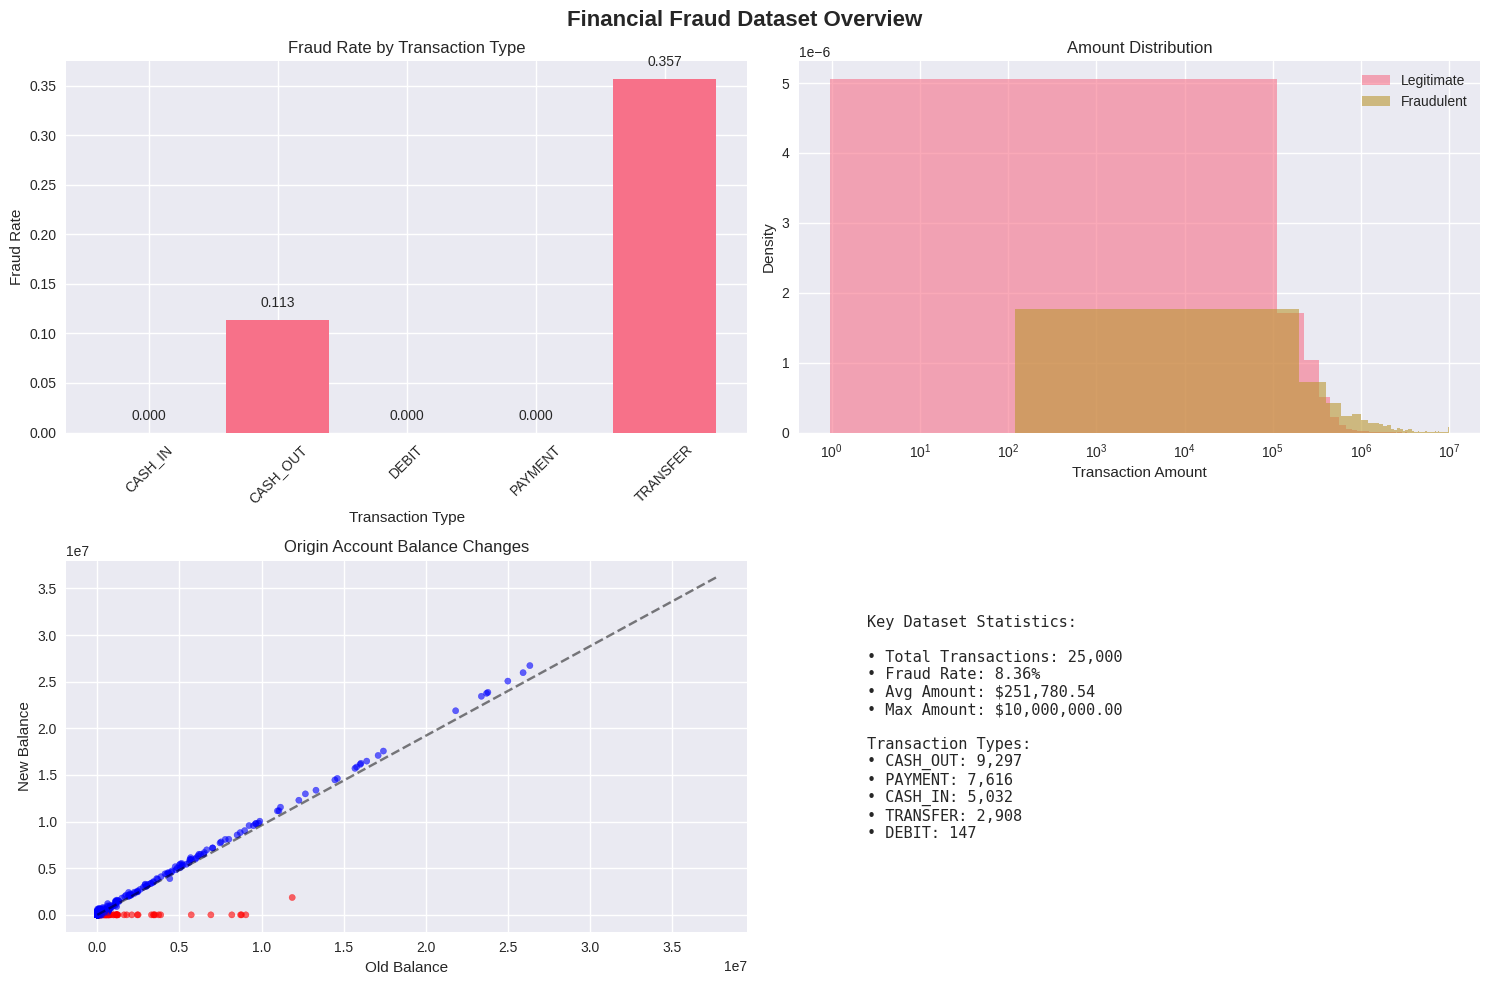

🔍 Key Insights:
   - TRANSFER and CASH_OUT have higher fraud rates
   - Fraudulent transactions often have suspicious balance patterns
   - Amount alone isn't a strong fraud indicator


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Financial Fraud Dataset Overview', fontsize=16, fontweight='bold')

# 1. Fraud by transaction type
fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'sum']).reset_index()
fraud_by_type['fraud_rate'] = fraud_by_type['sum'] / fraud_by_type['count']

bars = axes[0,0].bar(fraud_by_type['type'], fraud_by_type['fraud_rate'])
axes[0,0].set_title('Fraud Rate by Transaction Type')
axes[0,0].set_xlabel('Transaction Type')
axes[0,0].set_ylabel('Fraud Rate')
axes[0,0].tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars):
  height = bar.get_height()
  axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')

# 2. Amount distribution
axes[0,1].hist(df[df['isFraud']==0]['amount'], bins=50, alpha=0.6, label='Legitimate', density=True)
axes[0,1].hist(df[df['isFraud']==1]['amount'], bins=50, alpha=0.6, label='Fraudulent', density=True)
axes[0,1].set_title('Amount Distribution')
axes[0,1].set_xlabel('Transaction Amount')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].set_xscale('log')

# 3. Account Balance changes
df_sample = df.sample(1000, random_state=42)
colors = ['red' if f == 1 else 'blue' for f in df_sample['isFraud']]
axes[1,0].scatter(df_sample['oldbalanceOrg'], df_sample['newbalanceOrig'], c=colors, alpha=0.6, s=20)
axes[1,0].set_title('Origin Account Balance Changes')
axes[1,0].set_xlabel('Old Balance')
axes[1,0].set_ylabel('New Balance')
axes[1,0].plot([0, df['oldbalanceOrg'].max()], [0, df['newbalanceOrig'].max()], 'k--', alpha=0.5)

# 4. Key statistics
axes[1,1].axis('off')
stats_text = f"""
Key Dataset Statistics:

• Total Transactions: {len(df):,}
• Fraud Rate: {df['isFraud'].mean()*100:.2f}%
• Avg Amount: ${df['amount'].mean():,.2f}
• Max Amount: ${df['amount'].max():,.2f}

Transaction Types:
• CASH_OUT: {(df['type']=='CASH_OUT').sum():,}
• PAYMENT: {(df['type']=='PAYMENT').sum():,}
• CASH_IN: {(df['type']=='CASH_IN').sum():,}
• TRANSFER: {(df['type']=='TRANSFER').sum():,}
• DEBIT: {(df['type']=='DEBIT').sum():,}
"""
axes[1,1].text(0.1, 0.9, stats_text, transform=axes[1,1].transAxes,
              fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print("🔍 Key Insights:")
print("   - TRANSFER and CASH_OUT have higher fraud rates")
print("   - Fraudulent transactions often have suspicious balance patterns")
print("   - Amount alone isn't a strong fraud indicator")

### Feature Engineering & Selection

In [13]:
def engineer_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
  """
  Engineer features for both the NN and symbolic rules.

  Returns:
    X_raw: Features before preprocessing (readable for rules)
    y: Target variable (fraud labels)
    X_ids: Identifier columns for explanations
  """

  X = df.copy()

  # Rule-friendly derived features
  X['is_merchant_dest'] = X['nameDest'].astype(str).str.startswith("M").astype(int)
  X['is_transfer'] = (X['type'] == 'TRANSFER').astype(int)
  X['is_cashout'] = (X['type'] == 'CASH_OUT').astype(int)

  # Balance consistency checks
  X['delta_orig'] = (X['newbalanceOrig'] - X['oldbalanceOrg']) - X['amount']
  X['delta_dest'] = (X['newbalanceDest'] - X['oldbalanceDest']) - X['amount']
  X['abs_delta_orig'] = X['delta_orig'].abs()
  X['abs_delta_dest'] = X['delta_dest'].abs()

  # Risk ratios
  X['amount_over_orig'] = X['amount'] / (X['oldbalanceOrg'].replace(0, np.nan))
  X['amount_over_orig'] = X['amount_over_orig'].fillna(0).clip(0, 100)

  # Features for ML Model
  ml_cols_num = [
      'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
      'oldbalanceDest', 'newbalanceDest',
      'abs_delta_orig', 'abs_delta_dest',
      'amount_over_orig', 'is_merchant_dest', 'is_transfer', 'is_cashout'
  ]
  ml_cols_cat = ['type']

  X_raw = X[ml_cols_num + ml_cols_cat].copy()
  y = X['isFraud'].astype(int).copy()
  X_ids = X[['nameOrig', 'nameDest', 'isFlaggedFraud']].copy()

  return X_raw, y, X_ids

# Engineer features
X_raw, y, X_ids = engineer_features(df)

print(f"🔧 Feature engineering completed.")
print(f".  - Features Created: {len(X_raw.columns)} total")
print(f".  - Numerical Created: {len([c for c in X_raw.columns if X_raw[c].dtype != 'object'])}")
print(f".  - Categorical Created: {len([c for c in X_raw.columns if X_raw[c].dtype == 'object'])}")

# Show sample of engineered features
print("\n📋 Sample of engineered features:")
display(X_raw.head())

🔧 Feature engineering completed.
.  - Features Created: 13 total
.  - Numerical Created: 12
.  - Categorical Created: 1

📋 Sample of engineered features:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,abs_delta_orig,abs_delta_dest,amount_over_orig,is_merchant_dest,is_transfer,is_cashout,type
0,130,87595.74,138219.0,50623.26,0.00,87595.74,175191.48,0.00,0.633746,0,0,1,CASH_OUT
1,15,300480.90,219144.0,519624.90,154964.61,0.00,0.00,455445.51,1.371157,0,0,0,CASH_IN
2,35,8278.42,12127.0,3848.58,0.00,0.00,16556.84,8278.42,0.682644,1,0,0,PAYMENT
3,163,19676.82,0.0,0.00,0.00,0.00,19676.82,19676.82,0.000000,1,0,0,PAYMENT
4,17,85014.62,0.0,0.00,2457009.85,2561185.48,85014.62,19161.01,0.000000,0,0,1,CASH_OUT


### Part 1: Traditional Neural Network Approach

In [21]:
def build_nn_pipeline(num_cols: List[str], cat_cols: List[str], cfg: Config) -> Pipeline:
  """Build a neural network pipeline with preprocessing."""

  # Preprocessing Pipeline
  preprocessor = ColumnTransformer(
      transformers=[
          ('scaler', StandardScaler(), num_cols),
          ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
      ])

  # Neural Network
  mlp = MLPClassifier(
      hidden_layer_sizes=cfg.hidden_layers,
      activation='relu',
      solver='adam',
      alpha=1e-4,
      learning_rate_init=1e-3,
      max_iter=cfg.max_iter_mlp,
      early_stopping=True,
      validation_fraction=0.15,
      n_iter_no_change=10,
      random_state=cfg.random_state
  )

  # Combined Pipeline
  pipeline = Pipeline([
      ('preprocess', preprocessor),
      ('mlp', mlp)
  ])

  return pipeline

# Define column types
num_cols = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'abs_delta_orig', 'abs_delta_dest',
    'amount_over_orig', 'is_merchant_dest', 'is_transfer', 'is_cashout'
]
cat_cols = ['type']

# Split the data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=cfg.test_size, random_state=cfg.random_state, stratify=y
)

# Further splitting training data for validation (used later for combiner)
X_tr_raw, X_val_raw, y_tr, y_val = train_test_split(
    X_train_raw, y_train, test_size=cfg.test_size, random_state=cfg.random_state, stratify=y_train
)

print(f"🔧 Neural Network Pipeline built.")
print(f"   Data Split completed:")
print(f"   - Training: {len(X_tr_raw):,} samples")
print(f"   - Validation: {len(X_val_raw):,} samples")
print(f"   - Testing: {len(X_test_raw):,} samples")

# Build and train Neural Network
print(f"Training the neural network pipeline...")
nn_pipeline = build_nn_pipeline(num_cols, cat_cols, cfg)
nn_pipeline.fit(X_tr_raw, y_tr)

# Get predictions
nn_val_proba = nn_pipeline.predict_proba(X_val_raw)[:, 1]
nn_test_proba = nn_pipeline.predict_proba(X_test_raw)[:, 1]

# Evaluate the Neural Network
nn_roc = roc_auc_score(y_test, nn_test_proba)
nn_pr = average_precision_score(y_test, nn_test_proba)

print(f"\nNeural Network Results:")
print(f"   - ROC-AUC: {nn_roc:.4f}")
print(f"   - PR-AUC: {nn_pr:.4f}")
print(f"\nNeural Network trained successfully.")

🔧 Neural Network Pipeline built.
   Data Split completed:
   - Training: 16,000 samples
   - Validation: 4,000 samples
   - Testing: 5,000 samples
Training the neural network pipeline...

Neural Network Results:
   - ROC-AUC: 0.9914
   - PR-AUC: 0.9559

Neural Network trained successfully.
